In [1]:
import numpy as np
import torch.utils.data as dutils
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
TRAIN_SPLIT = 0.8

print('Loading the dataset into memory')
dataset = np.load('dataset.npy')
print(f'Finished loading the dataset, found {len(dataset)} items')

class Dataset(dutils.Dataset):
    def __init__(self, subset='training'):
        super().__init__()
    
        self.subset = subset
        
        val_split = (1 - TRAIN_SPLIT) / 2
    
        self.num_train = int(len(dataset) * TRAIN_SPLIT)
        self.num_val = int(len(dataset) * val_split)
    
        if subset == 'training':
            self.num_items = self.num_train
        elif subset == 'validation':
            self.num_items = self.num_val
        elif subset == 'testing':
            self.num_items = len(dataset) - self.num_train - self.num_val
        else:
            self.num_items = len(dataset)
            print('Warning: Unknown subset, using entire dataset')
    
        print(f'Using {self.num_items} items for {subset}')
	
    def __len__(self):
        return self.num_items
    
    def __getitem__(self, idx):
        offset = 0
        if self.subset == 'validation':
            offset += self.num_train
        if self.subset == 'testing':
            offset += self.num_train + self.num_val
        example = dataset[offset + idx]
        inputs = example[:-1]
        label = example[-1]
        return inputs, label
    
train_ds = Dataset(subset='training')
val_ds = Dataset(subset='validation')
test_ds = Dataset(subset='testing')

train_dl = dutils.DataLoader(train_ds, batch_size=256, shuffle=True)
val_dl = dutils.DataLoader(val_ds, batch_size=256, shuffle=True)
test_dl = dutils.DataLoader(test_ds, batch_size=256, shuffle=True)

Loading the dataset into memory
Finished loading the dataset, found 318011 items
Using 254408 items for training
Using 31801 items for validation
Using 31802 items for testing


In [3]:
len(dataset[0])

334

In [4]:
class TinyNet(nn.Module):
	def __init__(self):
		super().__init__()
		self.stack = nn.Sequential(
			nn.Linear(333, 128),
			nn.ReLU(True),

			nn.Linear(128, 64),
			nn.ReLU(True),

			nn.Linear(64, 1)
		)

	def forward(self, x):
		return self.stack(x)

In [5]:
device = (
	'cuda' if torch.cuda.is_available() else
	'mps' if torch.backends.mps.is_available() else
	'cpu'
)

print(f'Using {device}')

Using cuda


In [6]:
net = TinyNet()
net = net.to(device)

optim = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [7]:
def train(dl):
	avg_loss = 0
	avg_acc = 0
	for inputs, targets in tqdm(dl):
		inputs = inputs.to(device)
		targets = targets.to(device)

		preds = net(inputs)
		preds = preds.view(-1)
		loss = loss_fn(preds, targets)

		net.zero_grad()
		loss.backward()
		optim.step()

		avg_loss += loss.item()

		preds = torch.sigmoid(preds)
		acc = (preds.round() == targets).float().sum().item() / len(targets)
		avg_acc += acc
	avg_loss /= len(dl)
	avg_acc /= len(dl)

	return avg_loss, avg_acc

In [8]:
def test(dl):
	avg_loss = 0
	avg_acc = 0
	for inputs, targets in tqdm(dl):
		inputs = inputs.to(device)
		targets = targets.to(device)

		with torch.no_grad():
			preds = net(inputs)
		preds = preds.view(-1)
		loss = loss_fn(preds, targets)

		avg_loss += loss.item()

		preds = torch.sigmoid(preds)
		acc = (preds.round() == targets).float().sum().item() / len(targets)
		avg_acc += acc
	avg_loss /= len(dl)
	avg_acc /= len(dl)

	return avg_loss, avg_acc

In [9]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []
for epoch in range(20):
	print(f'Epoch {epoch+1}')
	t_loss, t_accuracy = train(train_dl)
	v_loss, v_accuracy = test(val_dl)
	train_losses.append(t_loss)
	train_accs.append(t_accuracy)
	val_losses.append(v_loss)
	val_accs.append(v_accuracy)
	print(f'Training Loss: {t_loss}')
	print(f'Training Accuracy: {t_accuracy}')
	print(f'Validation Loss: {v_loss}')
	print(f'Validation Accuracy : {v_accuracy}')

Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 550.60it/s]


Training Loss: 0.5286090557783902
Training Accuracy: 0.7113097334004024
Validation Loss: 0.5004058530330658
Validation Accuracy : 0.7381123903508772
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 599.60it/s]


Training Loss: 0.47069715422164027
Training Accuracy: 0.7582446239939638
Validation Loss: 0.44099189281463624
Validation Accuracy : 0.7781584429824561
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 617.96it/s]


Training Loss: 0.3860973085855814
Training Accuracy: 0.8146786971830986
Validation Loss: 0.35320362162590024
Validation Accuracy : 0.8349555921052632
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 637.04it/s]


Training Loss: 0.3010356667895672
Training Accuracy: 0.8628002389336016
Validation Loss: 0.2675198221206665
Validation Accuracy : 0.8808163377192982
Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 627.80it/s]


Training Loss: 0.2281870334680891
Training Accuracy: 0.9008989876760563
Validation Loss: 0.20237128579616548
Validation Accuracy : 0.913109649122807
Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 556.45it/s]


Training Loss: 0.17383483013276843
Training Accuracy: 0.9260145246478872
Validation Loss: 0.17497434318065644
Validation Accuracy : 0.925547149122807
Epoch 7


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 529.86it/s]


Training Loss: 0.13778503967722658
Training Accuracy: 0.9425658639336015
Validation Loss: 0.13489769113063813
Validation Accuracy : 0.943594298245614
Epoch 8


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 620.11it/s]


Training Loss: 0.10777424110972905
Training Accuracy: 0.9562242203219317
Validation Loss: 0.09644777977466583
Validation Accuracy : 0.962375548245614
Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 597.54it/s]


Training Loss: 0.09012020658889047
Training Accuracy: 0.9636071114185111
Validation Loss: 0.12186016142368317
Validation Accuracy : 0.9484380482456141
Epoch 10


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 467.48it/s]


Training Loss: 0.0742002910272906
Training Accuracy: 0.9707054828973843
Validation Loss: 0.06908107888698578
Validation Accuracy : 0.974140899122807
Epoch 11


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 600.39it/s]


Training Loss: 0.06230703947814537
Training Accuracy: 0.9757806212273642
Validation Loss: 0.08891872805356979
Validation Accuracy : 0.963547149122807
Epoch 12


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 567.10it/s]


Training Loss: 0.052940498154902725
Training Accuracy: 0.979398736167002
Validation Loss: 0.05342160341143608
Validation Accuracy : 0.979844298245614
Epoch 13


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 602.47it/s]


Training Loss: 0.04664325604582546
Training Accuracy: 0.9823967240945675
Validation Loss: 0.04825916504859924
Validation Accuracy : 0.981515899122807
Epoch 14


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 654.47it/s]


Training Loss: 0.04616852931376599
Training Accuracy: 0.982296277665996
Validation Loss: 0.10745564526319504
Validation Accuracy : 0.9574857456140351
Epoch 15


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 627.03it/s]


Training Loss: 0.03737597401681125
Training Accuracy: 0.9859700389839035
Validation Loss: 0.04376292610168457
Validation Accuracy : 0.98384375
Epoch 16


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 632.83it/s]


Training Loss: 0.030292847940287883
Training Accuracy: 0.9891711204728371
Validation Loss: 0.07561223521828651
Validation Accuracy : 0.970048245614035
Epoch 17


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 520.28it/s]


Training Loss: 0.030960122763762022
Training Accuracy: 0.9889174107142857
Validation Loss: 0.03396593734622002
Validation Accuracy : 0.9878755482456141
Epoch 18


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 584.02it/s]


Training Loss: 0.028352806324015562
Training Accuracy: 0.98985726861167
Validation Loss: 0.0355987269282341
Validation Accuracy : 0.987797149122807
Epoch 19


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 580.25it/s]


Training Loss: 0.026501556742239286
Training Accuracy: 0.9906712147887324
Validation Loss: 0.025539326705038546
Validation Accuracy : 0.991375
Epoch 20


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 588.88it/s]

Training Loss: 0.027002797202161238
Training Accuracy: 0.9900642920020121
Validation Loss: 0.020722067594528198
Validation Accuracy : 0.993484649122807


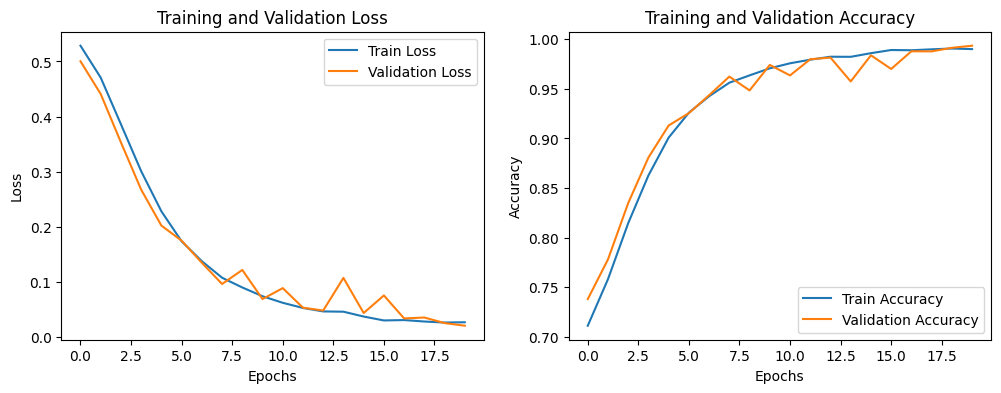

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

plt.show()

In [11]:
loss, accuracy = test(test_dl)
print(f"Loss: {loss}, Accuracy: {accuracy}")

100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 713.69it/s]

Loss: 0.019437514048069714, Accuracy: 0.99359375


In [12]:
def get_accuracy_by_minute():
    acc_dic = {}
    count_dic = {}
    for batch, targets in tqdm(test_dl):
        batch = batch.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            predictions = net(batch)
        predictions = torch.sigmoid(predictions)
        for i in range(len(batch)):
            tstep = str(int(batch[i][-1] * 30))
            if tstep in acc_dic:
                if predictions[i].round() == targets[i]:
                    acc_dic[tstep] += 1
                count_dic[tstep] += 1
            else:
                acc_dic[tstep] = 0
                if predictions[i].round() == targets[i]:
                    acc_dic[tstep] = 1
                count_dic[tstep] = 1
    return acc_dic, count_dic

In [13]:
acc_dic, count_dic = get_accuracy_by_minute()

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 32.58it/s]


In [14]:
acc_dic

{'11': 1045,
 '32': 352,
 '7': 1042,
 '13': 1029,
 '27': 745,
 '26': 797,
 '18': 958,
 '12': 992,
 '24': 894,
 '25': 828,
 '21': 957,
 '17': 991,
 '10': 1032,
 '0': 1048,
 '31': 461,
 '19': 947,
 '28': 628,
 '3': 1013,
 '6': 1076,
 '2': 1079,
 '15': 1048,
 '14': 1068,
 '16': 1072,
 '22': 893,
 '23': 918,
 '20': 937,
 '29': 563,
 '30': 538,
 '8': 1050,
 '34': 258,
 '9': 1020,
 '36': 163,
 '4': 1051,
 '1': 1011,
 '5': 1031,
 '37': 141,
 '35': 201,
 '38': 104,
 '42': 43,
 '33': 303,
 '41': 47,
 '39': 81,
 '44': 26,
 '45': 11,
 '46': 13,
 '43': 21,
 '40': 49,
 '50': 3,
 '49': 2,
 '47': 6,
 '54': 3,
 '48': 4,
 '51': 2,
 '52': 2}

In [15]:
for n in acc_dic.keys():
    acc_dic[n] /= count_dic[n]

In [16]:
idx = 0
acc_by_time = []
while str(idx) in acc_dic:
    n = acc_dic[str(idx)]
    acc_by_time.append(n)
    idx += 1

In [17]:
acc_by_time[20]

0.9968085106382979

In [18]:
acc_by_time

[0.9703703703703703,
 0.9711815561959655,
 0.974706413730804,
 0.9759152215799615,
 0.9896421845574388,
 0.9932562620423893,
 0.9935364727608494,
 0.9886148007590133,
 0.9971509971509972,
 0.9951219512195122,
 0.9961389961389961,
 1.0,
 0.9979879275653923,
 1.0,
 0.9981308411214953,
 0.9961977186311787,
 0.9981378026070763,
 0.9949799196787149,
 1.0,
 0.9989451476793249,
 0.9968085106382979,
 0.9989561586638831,
 0.9944320712694877,
 0.998911860718172,
 0.9977678571428571,
 0.9987937273823885,
 0.9937655860349127,
 0.9973226238286479,
 1.0,
 1.0,
 0.9962962962962963,
 1.0,
 0.9971671388101983,
 1.0,
 0.9961389961389961,
 1.0,
 1.0,
 0.9929577464788732,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

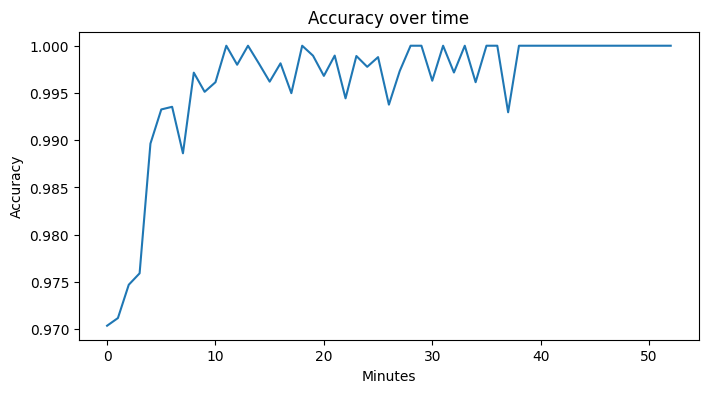

In [19]:
plt.figure(figsize=(8, 4))
plt.title('Accuracy over time')
plt.plot(acc_by_time)
plt.xlabel('Minutes')
plt.ylabel('Accuracy')
plt.show()

In [20]:
inputs, targets = next(iter(train_dl))

In [21]:
len(inputs)

256

In [22]:
len(targets)

256

In [23]:
net = net.cpu()

In [24]:
torch.save(net, 'net.pth')